## QA on Documents

给定一段文本，可能是从 PDF 文件、网页或某个公司的内部文档集合中提取出来的，您可以使用 LLM 来回答关于这些文档内容的问题，已帮助用户深入了解并获取所需的信息。

意义：将 LLM 与他们最初未经训练的数据结合起来

In [1]:
import os

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

In [36]:
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA
from langchain.document_loaders import CSVLoader
# 基于内存的向量存储
from langchain.vectorstores import DocArrayInMemorySearch
from IPython.display import display, Markdown

In [3]:
file = 'data/OutdoorClothingCatalog_1000.csv'
loader = CSVLoader(file_path=file)

In [4]:
from langchain.indexes import VectorstoreIndexCreator

In [5]:
! pip install -q "langchain[docarray]"

In [37]:
# create index on csv loader, using memory vector store
index = VectorstoreIndexCreator(
    vectorstore_cls=DocArrayInMemorySearch
).from_loaders([loader])

In [7]:
query = "Please list all your shirts with sun protection \
in a table in markdown and summarize each one."

In [35]:
response = index.query(query)

display(Markdown(response))



| Shirt Name | Sun Protection |
| --- | --- |
| Smooth Comfort Check Shirt, Slightly Fitted | TrueCool® fabric wicks moisture away from your skin and helps it dry quickly |
| Refresh Swimwear, V-Neck Tankini Contrasts | UPF 50+ rated – the highest rated sun protection possible |
| Infant and Toddler Girls' Coastal Chill Swimsuit, Two-Piece | UPF 50+ rated fabric provides the highest rated sun protection possible, blocking 98% of the sun's harmful rays |
| EcoFlex 3L Storm Pants | TEK O2 technology offers the most breathability we've ever tested |

The Smooth Comfort Check Shirt, Slightly Fitted has TrueCool® fabric that wicks moisture away from the skin and helps it dry quickly. The Refresh Swimwear, V-Neck Tankini Contrasts has UPF 50+ rated sun protection that blocks the sun's harmful rays. The Infant and Toddler Girls' Coastal Chill Swimsuit, Two-Piece also has UPF 50+ rated fabric that blocks 98% of the sun's harmful rays. Lastly, the EcoFlex 3L Storm Pants has TEK O2 technology that offers the most breathability

## Under the hood

LLM 一次仅能接收指定大小的输入。如果我们有很大的文档，如何让 LLM 接收并处理所有内容呢？

这时候就轮到 嵌入 和 向量存储 出场了！

***嵌入***

1. 嵌入向量是一组数值，它表示了指定文本片段的语义含义
2. 相同内容的文本具有相似的向量

***向量数据库***

向量数据库：用来存储嵌入向量。

当我们获得一个大的输入文档，并需要将它保存在向量数据库时：

1. 首先要将其**分解为较小的块**。这有助于创建比原始文档更小的文本片段，这很有用，因为我们可能无法将整个文档传递给 LLM
2. 然后为每个这些块**创建嵌入**，并将其**存储**在向量数据库中

存储向量的过程也是**创建索引**的过程。

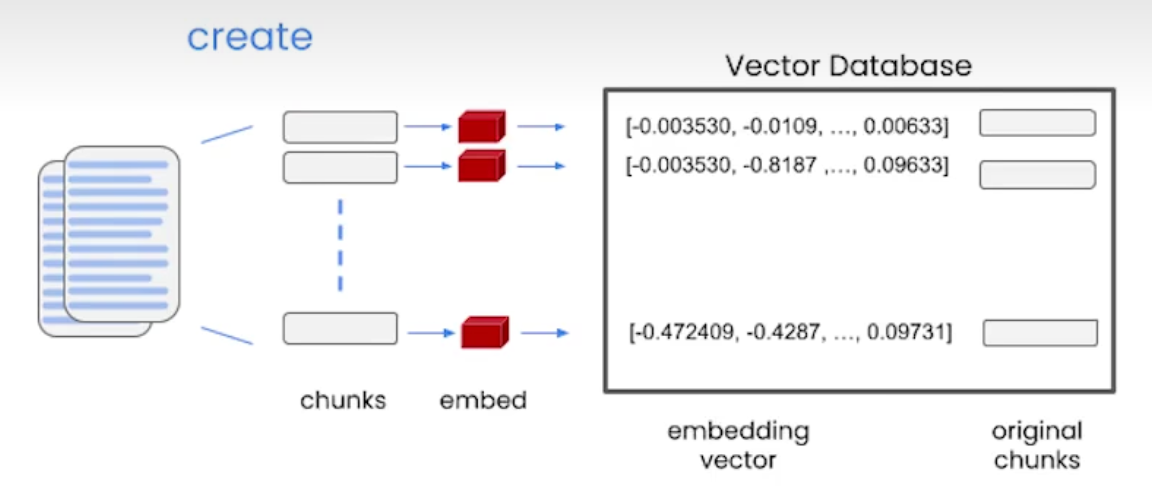

有了这个索引，我们可以在运行时使用它查找与输入最相关的文本片段：

1. 首先为该查询创建一个嵌入
2. 将其与向量数据库中的所有向量进行比较，选择最相似的前 n 个
3. 将他们作为提示传递给 LLM，以获得最终答案

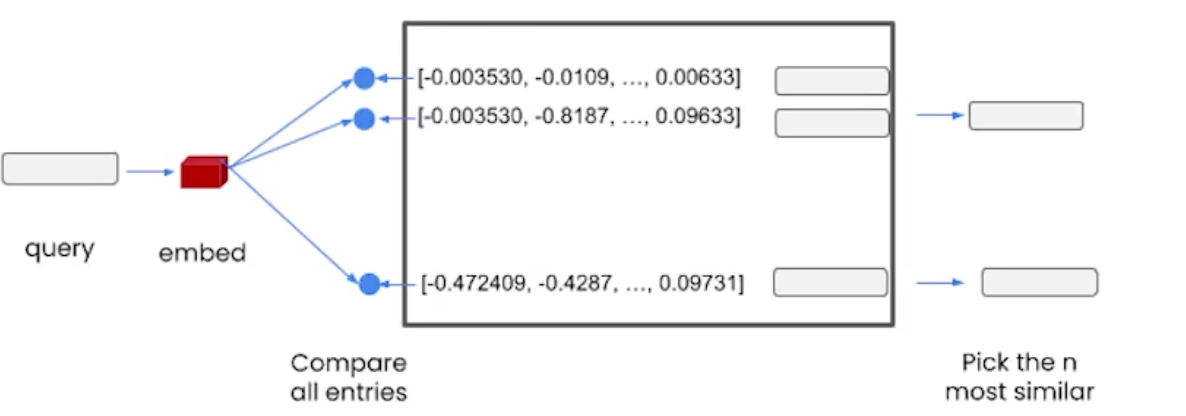


In [9]:
csv_loader = CSVLoader(file_path=file)

In [10]:
docs = loader.load()

print(len(docs))
print(docs[0])

6
page_content=": 0\nname: Women's Campside Oxfords\ndescription: This ultracomfortable lace-to-toe Oxford boasts a super-soft canvas, thick cushioning, and quality construction for a broken-in feel from the first time you put them on. \n\nSize & Fit: Order regular shoe size. For half sizes not offered, order up to next whole size. \n\nSpecs: Approx. weight: 1 lb.1 oz. per pair. \n\nConstruction: Soft canvas material for a broken-in feel and look. Comfortable EVA innersole with Cleansport NXT® antimicrobial odor control. Vintage hunt, fish and camping motif on innersole. Moderate arch contour of innersole. EVA foam midsole for cushioning and support. Chain-tread-inspired molded rubber outsole with modified chain-tread pattern. Imported. \n\nQuestions? Please contact us for any inquiries." metadata={'source': 'data/OutdoorClothingCatalog_1000.csv', 'row': 0}


**demo**

In [11]:
from langchain.embeddings import OpenAIEmbeddings
embeddings = OpenAIEmbeddings()

In [12]:
embed = embeddings.embed_query("Hi, my name is Eugene.")

print(len(embed))
print(embed[0:5])

1536
[-0.007497557593235811, -0.0018281672759027654, -0.02291345457212818, -0.01912642309695443, -0.023525501154312026]


**demo ends.**

In [13]:
db = DocArrayInMemorySearch.from_documents(
    docs,
    embeddings
)

In [15]:
query_docs = db.similarity_search("Please suggest a shirt with sunblocking")

In [16]:
print(len(query_docs))
print(query_docs[0])

4
page_content=": 5\nname: Smooth Comfort Check Shirt, Slightly Fitted\ndescription: Our men's slightly fitted check shirt is the perfect choice for your wardrobe! Customers love how it fits right out of the dryer. Size & Fit: Slightly Fitted, Relaxed through the chest and sleeve with a slightly slimmer waist. Fabric & Care: 100% cotton poplin, with wrinkle-free performance that won't wash out. Our innovative TrueCool® fabric wicks moisture away from your skin and helps it dry quickly. Additional Features: Traditional styling with a button-down collar and a single patch pocket. Imported." metadata={'source': 'data/OutdoorClothingCatalog_1000.csv', 'row': 5}


In [17]:
retriever = db.as_retriever()

In [18]:
llm = ChatOpenAI(temperature=0.0)

In [20]:
qdocs = "".join([query_docs[i].page_content for i in range(len(query_docs))])
qdocs

": 5\nname: Smooth Comfort Check Shirt, Slightly Fitted\ndescription: Our men's slightly fitted check shirt is the perfect choice for your wardrobe! Customers love how it fits right out of the dryer. Size & Fit: Slightly Fitted, Relaxed through the chest and sleeve with a slightly slimmer waist. Fabric & Care: 100% cotton poplin, with wrinkle-free performance that won't wash out. Our innovative TrueCool® fabric wicks moisture away from your skin and helps it dry quickly. Additional Features: Traditional styling with a button-down collar and a single patch pocket. Imported.: 3\nname: Refresh Swimwear, V-Neck Tankini Contrasts\ndescription: Whether you're going for a swim or heading out on an SUP, this watersport-ready tankini top is designed to move with you and stay comfortable. All while looking great in an eye-catching colorblock style. \n\nSize & Fit\nFitted: Sits close to the body.\n\nWhy We Love It\nNot only does this swimtop feel good to wear, its fabric is good for the earth too

In [ ]:
# timeouttt 🥲
response = llm.call_as_llm(f"{qdocs}\n\n Question: Please list all your shirts with sun protection \
in a table in markdown and summarize each one.")

In [ ]:
display(Markdown(response))

**简化：使用检索链进行调用**

In [22]:
qa_stuff = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    verbose=True
)

***chain_type***: stuff 表示最简单的方法，它只是将所有文档都放入上下文中，并对语言模型进行依次调用

In [31]:
query = "Please list all the shirts with sun protection in a table \
in markdown and summarize each one."

resp = qa_stuff.run(query)

display(Markdown(resp))



> Entering new RetrievalQA chain...

> Finished chain.


| Shirt Name | Sun Protection | Summary |
|------------|----------------|---------|
| Refresh Swimwear, V-Neck Tankini Contrasts | UPF 50+ rated | This tankini top is designed for watersports and offers UPF 50+ sun protection. It is made from recycled nylon and Lycra spandex for comfort and stretch. The lightweight racerback straps and V-neck silhouette add to its flattering design. |
| Infant and Toddler Girls' Coastal Chill Swimsuit, Two-Piece | UPF 50+ rated | This two-piece swimsuit for toddlers offers UPF 50+ sun protection. It features bright colors, ruffles, and exclusive prints. The four-way-stretch and chlorine-resistant fabric ensures durability and shape retention. The crossover no-slip straps and fully lined bottom provide a secure fit and maximum coverage. |


In [33]:
response = index.query(query)
display(Markdown(response))



| Shirt Name | Sun Protection |
| --- | --- |
| Smooth Comfort Check Shirt, Slightly Fitted | TrueCool® fabric wicks moisture away from your skin and helps it dry quickly |
| Refresh Swimwear, V-Neck Tankini Contrasts | UPF 50+ rated – the highest rated sun protection possible |
| Infant and Toddler Girls' Coastal Chill Swimsuit, Two-Piece | UPF 50+ rated fabric provides the highest rated sun protection possible, blocking 98% of the sun's harmful rays |
| EcoFlex 3L Storm Pants | TEK O2 technology offers the most breathability we've ever tested |

The Smooth Comfort Check Shirt, Slightly Fitted has TrueCool® fabric that wicks moisture away from the skin and helps it dry quickly. The Refresh Swimwear, V-Neck Tankini Contrasts has UPF 50+ rated sun protection that blocks the sun's harmful rays. The Infant and Toddler Girls' Coastal Chill Swimsuit, Two-Piece also has UPF 50+ rated fabric that blocks 98% of the sun's harmful rays. Lastly, the EcoFlex 3L Storm Pants has TEK O2 technology that offers the most breathability

---

BESIDES, when creating ***VectorstoreIndexCreator***, we can provide an existed embedding.

```python
index = VectorstoreIndexCreator(
    vectorstore_cls=DocArrayInMemorySearch, # 向量存储类
    embedding=embeddings                    # 已有的嵌入
).from_loaders([loader])                    # 从加载器加载数据
```

### chain type of RetrievalQA

**1. stuff method**

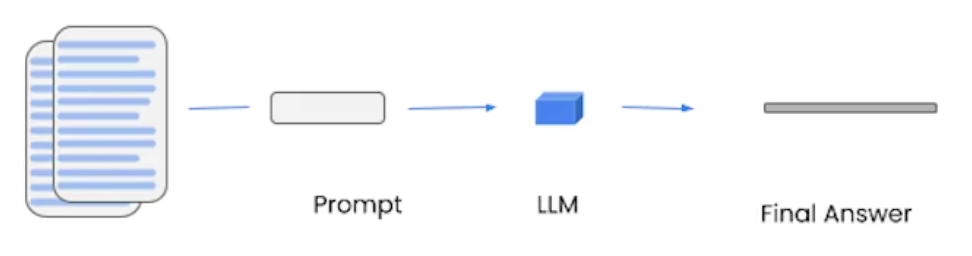

Stuffing is the simplest method. You simply stuff all data into the prompts as context to pass to the LLM.

**Pros:** It makes a single call to the LLM. The LLM has access to all the data at once.
**Cons:** LLMs have a context length, and for large documents or many documents this will not work as it will result in a prompt larger than the context lenght.

---

**2. map reduce**

basic steps:

1. pass all the chunks along with the question to LLM, get back responses
2. use another LLM call to summarize all the individual response into a final answer

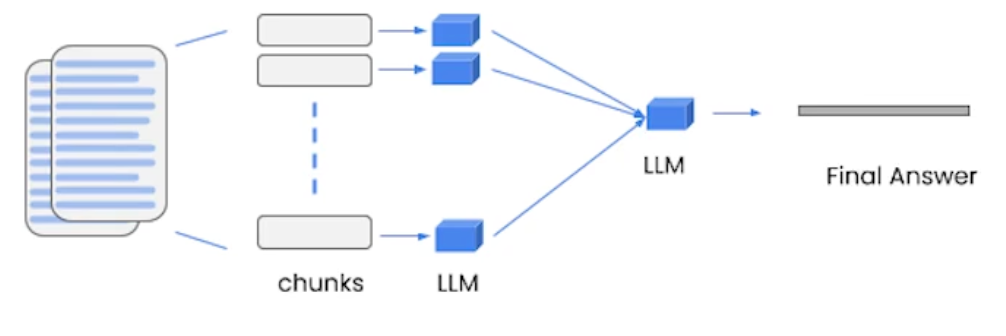

---

**3.Refine**

循环处理多个文档，基于前一个文档处理结果进行构建，对于合并信息和逐步构建答案非常有用。

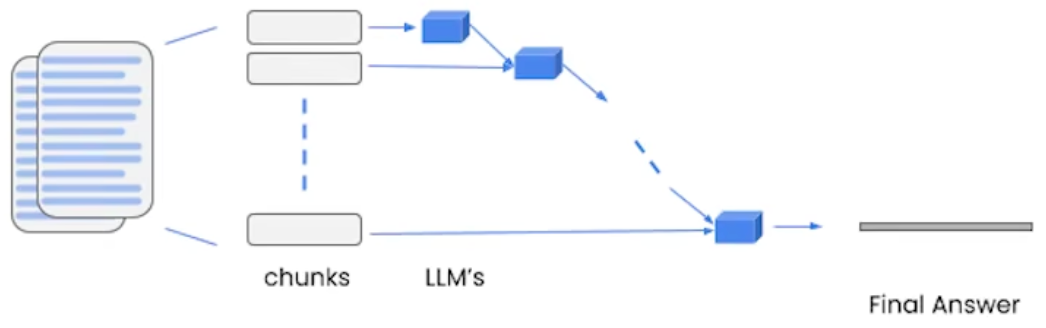

---

**4.map rerank**

为每个 chunk 执行一次 LLM 调用，并要求它返回一个分数，然后选择最高分

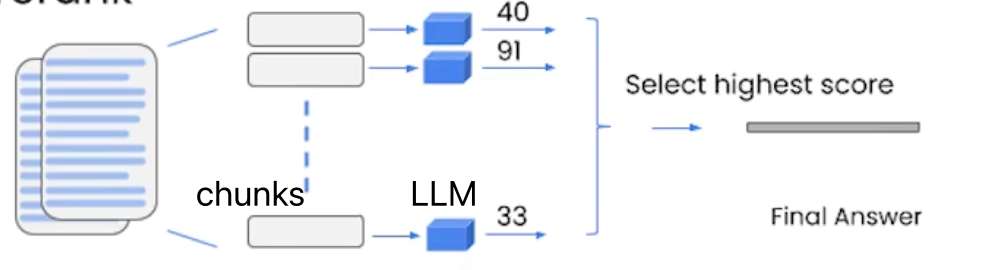
